In [9]:

# ## 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os


In [10]:
# ## 2. Load Feature Data
import pandas as pd
features_path = "../data/processed/walmart_with_features.csv"
df = pd.read_csv(features_path, parse_dates=["Date"])

print(" Data Loaded Successfully:", df.shape)
df.head()


 Data Loaded Successfully: (6255, 18)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,week,day_of_week,is_weekend,sales_lag_1,sales_lag_2,sales_lag_4,rolling_mean_4w,rolling_std_4w
0,1,2010-03-05,0.914805,0,-0.767955,-1.598328,1.010624,0.056964,2010,3,9,4,0,0.654458,1.017382,1.074309,0.954337,0.201620
1,1,2010-03-12,0.707959,0,-0.155815,-1.506821,1.011399,0.056964,2010,3,10,4,0,0.914805,0.654458,1.071198,0.914461,0.185078
2,1,2010-03-19,0.767132,0,-0.329861,-1.391349,1.007206,0.056964,2010,3,11,4,0,0.707959,0.914805,1.017382,0.823651,0.171125
3,1,2010-03-26,0.644951,0,-0.499568,-1.365204,1.002185,0.056964,2010,3,12,4,0,0.767132,0.707959,0.654458,0.761088,0.112336
4,1,2010-04-02,0.986875,0,0.087089,-1.393527,0.997164,-0.101907,2010,4,13,4,0,0.644951,0.767132,0.914805,0.758712,0.115403


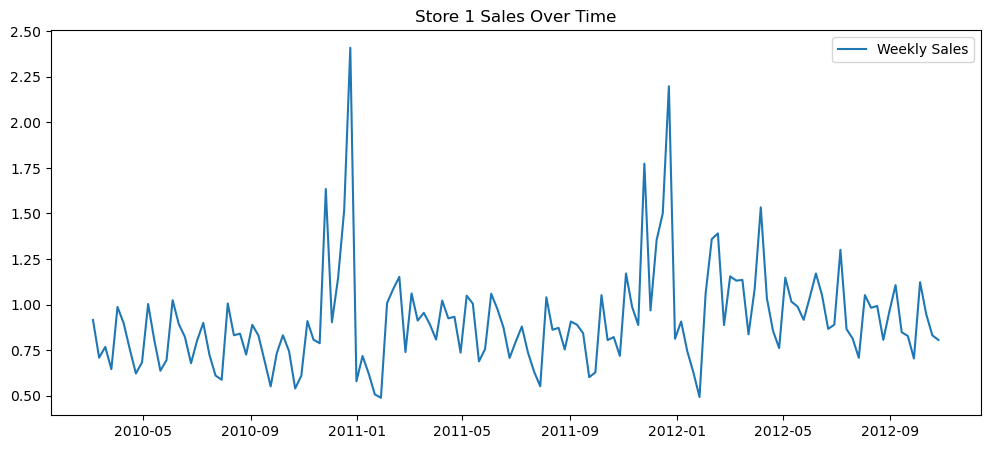

In [11]:
# ## 3. Filter Data for a Single Store (Example: Store 1)
store_id = 1
store_df = df[df["Store"] == store_id].copy()
store_df = store_df.sort_values("Date")

plt.figure(figsize=(12,5))
plt.plot(store_df["Date"], store_df["Weekly_Sales"], label="Weekly Sales")
plt.title(f"Store {store_id} Sales Over Time")
plt.legend()
plt.show()


In [12]:
# ## 4. Check Stationarity (ADF Test)
result = adfuller(store_df["Weekly_Sales"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -4.999601536285936
p-value: 2.223348873864394e-05


In [13]:
# ## 5. Fit SARIMA Model
y = store_df.set_index("Date")["Weekly_Sales"]

sarima_model = sm.tsa.statespace.SARIMAX(y, 
                                         order=(1,1,1), 
                                         seasonal_order=(1,1,1,52), 
                                         enforce_stationarity=False, 
                                         enforce_invertibility=False)
sarima_res = sarima_model.fit(disp=False)
print(sarima_res.summary())


c:\Users\FR4001TU\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\FR4001TU\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\FR4001TU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  139
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                  22.178
Date:                            Fri, 29 Aug 2025   AIC                            -34.355
Time:                                    00:24:53   BIC                            -27.026
Sample:                                03-05-2010   HQIC                           -31.926
                                     - 10-26-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0592      0.263     -0.225      0.822      -0.575       0.456
ma.L1         -1.0719      0.237   

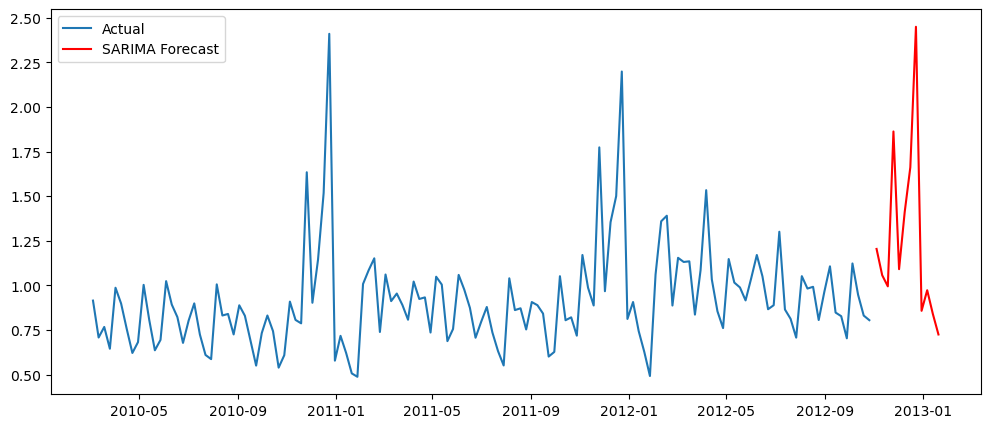

In [15]:
# ## 6. Forecast
forecast_steps = 12
sarima_forecast = sarima_res.forecast(steps=forecast_steps)

plt.figure(figsize=(12,5))
plt.plot(y.index, y, label="Actual")
plt.plot(pd.date_range(y.index[-1], periods=forecast_steps+1, freq="W")[1:], 
         sarima_forecast, label="SARIMA Forecast", color="red")
plt.legend()
plt.show()


In [16]:
# ### 7. Evaluate Model on Unseen Data

# First, let's create a train-test split.
# We'll use the last `forecast_steps` as our test set.
train_size = len(y) - forecast_steps
train_data = y[:train_size]
test_data = y[train_size:]

# Now, refit the model on the training data only.
# (Note: In a real-world scenario, you might want to re-run your model search on the smaller training set).
try:
    final_model = sm.tsa.statespace.SARIMAX(
        train_data,
        order=(p, d, q),  # Use the parameters you found
        seasonal_order=(P, D, Q, S),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Get predictions for the test set
    pred = final_model.get_prediction(start=test_data.index[0], end=test_data.index[-1])
    test_pred = pred.predicted_mean

    # Ensure the indices are aligned
    test_pred.index = test_data.index

    # Calculate evaluation metrics
    sarima_mae = mean_absolute_error(test_data, test_pred)
    sarima_rmse = np.sqrt(mean_squared_error(test_data, test_pred))
    sarima_r2 = r2_score(test_data, test_pred)

    print("\nSARIMA - Evaluation on Test Data:")
    print(f"MAE:  {sarima_mae:.2f}")
    print(f"RMSE: {sarima_rmse:.2f}")
    print(f"R²:   {sarima_r2:.4f}")
    
except Exception as e:
    print(f"Error during evaluation: {e}")

Error during evaluation: name 'p' is not defined


In [18]:
# ### 7. Evaluate Model on Unseen Data

# First, let's create a train-test split.
# We'll use the last `forecast_steps` as our test set.
train_size = len(y) - forecast_steps
train_data = y[:train_size]
test_data = y[train_size:]

# Now, refit the model on the training data only.
# (Note: In a real-world scenario, you might want to re-run your model search on the smaller training set).
try:
    final_model = sm.tsa.statespace.SARIMAX(
        train_data,
        order=(p, d, q),  # Use the parameters you found
        seasonal_order=(P, D, Q, S),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Get predictions for the test set
    pred = final_model.get_prediction(start=test_data.index[0], end=test_data.index[-1])
    test_pred = pred.predicted_mean

    # Ensure the indices are aligned
    test_pred.index = test_data.index

    # Calculate evaluation metrics
    sarima_mae = mean_absolute_error(test_data, test_pred)
    sarima_rmse = np.sqrt(mean_squared_error(test_data, test_pred))
    sarima_r2 = r2_score(test_data, test_pred)

    print("\nSARIMA - Evaluation on Test Data:")
    print(f"MAE:  {sarima_mae:.2f}")
    print(f"RMSE: {sarima_rmse:.2f}")
    print(f"R²:   {sarima_r2:.4f}")
    
except Exception as e:
    print(f"Error during evaluation: {e}")

Error during evaluation: name 'p' is not defined
